In [1]:
import pennylane as qml
import torch
import torch.autograd as autograd

n_wires = 4

@qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
def circuit(x, theta):

    for i in range(n_wires):
        qml.RY(2*torch.arccos(x),wires = i)
    
    qml.BasicEntanglerLayers(weights=theta, wires=range(n_wires))
    # for i in range(n_wires):
    #     qml.RX(theta[i, 0], wires=i)
    #     qml.RY(theta[i, 1], wires=i)
    #     qml.RX(theta[i, 2], wires=i)
    #     qml.CNOT(wires=[i, (i + 1) % n_wires])

    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(x, theta, bias):
    vcircuit = torch.vmap(circuit, in_dims=(0,None))
    return vcircuit(x, theta) + bias

def loss_fnc(theta:torch.Tensor, bias:torch.Tensor) ->torch.Tensor:
    theta.requires_grad =True
    bias.requires_grad = True
    x = torch.linspace(0.01,.99,21, requires_grad=True)

    u_pred = my_model(x, theta, bias)
    grad_outputs = torch.ones_like(u_pred)
    dudx = autograd.grad(u_pred, x, grad_outputs=grad_outputs, create_graph=True)[0]
    res = dudx - (4 * x**3 + x**2 - 2 * x - 0.5)
    loss_pde = torch.mean(res**2)

    u_0_pre = my_model(torch.zeros_like(x), theta, bias)
    u_0 = torch.ones_like(x)
    loss_boundary = torch.mean((u_0_pre - u_0)**2)
    return loss_boundary + loss_pde

# theta = torch.rand((n_wires,3), requires_grad=True)
theta = torch.rand((3,n_wires), requires_grad=True)
bias = torch.rand(1, requires_grad=True)
opt = torch.optim.Adam([theta, bias], lr=0.01)
loss_history = []

def optimize():
    for i in range(100):
        opt.zero_grad()
        loss = loss_fnc(theta, bias)
        loss.backward()
        opt.step()
        if i%10 == 0: print(f"Step: {i}  Loss: {loss}")
        loss_history.append(loss.detach())


In [2]:
%timeit -n1 -r3 optimize()

Step: 0  Loss: 102.99933613770813
Step: 10  Loss: 67.15407097353683
Step: 20  Loss: 31.76791852582427
Step: 30  Loss: 12.05264312379322
Step: 40  Loss: 5.968728983185603
Step: 50  Loss: 3.8173145761670675
Step: 60  Loss: 2.4689995702550647
Step: 70  Loss: 1.7068640016449912
Step: 80  Loss: 1.3592604928228633
Step: 90  Loss: 1.1714062260280267
Step: 0  Loss: 1.0086981341682284
Step: 10  Loss: 0.8475757288618562
Step: 20  Loss: 0.6970133353380596
Step: 30  Loss: 0.564742419993693
Step: 40  Loss: 0.45410719803089084
Step: 50  Loss: 0.3653832706928739
Step: 60  Loss: 0.29687629929801407
Step: 70  Loss: 0.24571634251662378
Step: 80  Loss: 0.2084041419129088
Step: 90  Loss: 0.1814282762526922
Step: 0  Loss: 0.16175601260719308
Step: 10  Loss: 0.14702796777917015
Step: 20  Loss: 0.13555099146177785
Step: 30  Loss: 0.12618812469705976
Step: 40  Loss: 0.11821461686705348
Step: 50  Loss: 0.11119016563714368
Step: 60  Loss: 0.10485355893610748
Step: 70  Loss: 0.09905339515666256
Step: 80  Loss: 0

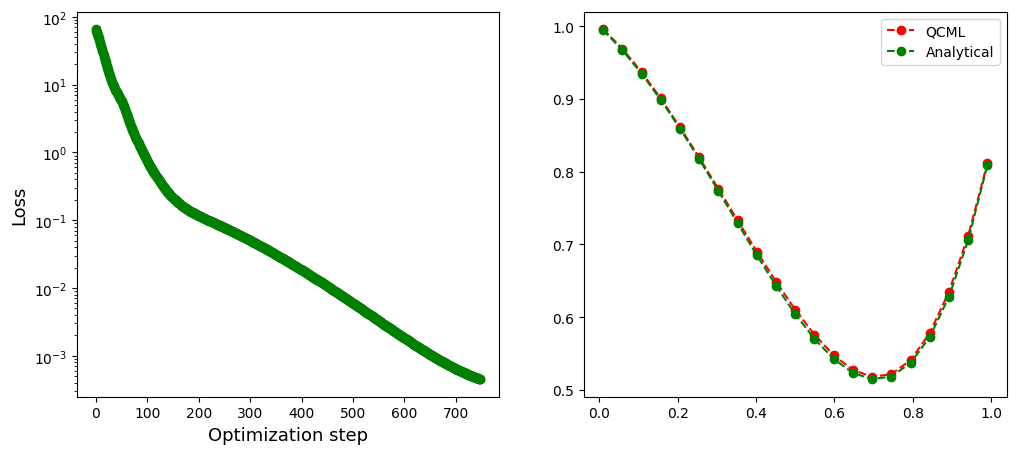

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_yscale('log')
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = torch.linspace(0.01,.99,21)
f_qc = my_model(x, theta, bias).detach()
f_an = x**4 + (1 / 3) * x**3 - x**2 - (1 / 2) * x + 1
ax2.plot( x, f_qc, "ro", ls="dashed")
ax2.plot( x, f_an, "go", ls="dashed")
ax2.legend(["QCML", "Analytical"])

plt.show()